# Emulating Hedge Fund Strategies: A Multi-Sector Investment Approach with Machine Learning (Long/Short Sector Rotation)


---

### Strategic Framework

1. **Investment Strategy Overview**:  
   This strategy is designed to emulate hedge fund approaches by leveraging various sectors. Growth sectors such as telecommunications, technology, shipping, and energy are targeted, while hedging sectors like utilities, healthcare, and bonds & ETFs are utilized for risk management.

2. **Machine Learning Model Utilization**:  
   We employ multiple technical indicators to train machine learning models, including Support Vector Machines (SVM), Random Forest (RF), and Deep Neural Networks (DNN). These models are pivotal in identifying profitable trading opportunities based on historical data.

3. **Sector-Wise Returns and Cumulative Returns**:  
   Upon training the machine learning models, we evaluate their performance through sector-wise returns and cumulative returns. This analysis reveals how each model performs over the defined timeline, highlighting the varying returns generated by different models.

4. **Dynamic Threshold Definition**:  
   A dynamic threshold is established based on market conditions, as indicated by **FRED data**. Actions such as 'long' or 'short' positions for each sector are determined based on whether sector returns exceed this threshold.

5. **Economic Indicators for Threshold Determination**:  
   Key economic indicators, including the Consumer Price Index (CPI), Federal Funds Rate, and GDP growth, are utilized to define the threshold. If the sector returns surpass this threshold, a 'long' position is taken; otherwise, a 'short' position is adopted.

6. **Initial Investment Consideration**:  
   A user-defined initial investment amount, consistent across all machine learning models, is considered to calculate the total return on the initial investment for each model.

7. **Performance Metrics Calculation**:  
   We assess various performance metrics, including volatility, Sharpe ratio, alpha, maximum drawdown, and risk-reward ratio for each machine learning model. These metrics are compared against benchmark indices, such as the S&P 500, to evaluate the relative performance.

8. **Stress Testing under Recession Scenarios**:  
   Finally, we conduct stress testing to simulate performance under recession scenarios, allowing for a comprehensive assessment of the models' resilience in adverse economic conditions.



#### I have included detailed comments to clarify the function's logic and the overall flow of the strategy.

---



In [26]:
# If needed - pip install pandas numpy yfinance TA-Lib scikit-learn tensorflow matplotlib holidays requests


In [32]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import holidays  # This package provides stock market holiday dates

# Define assets by sector
sectors = {
    'Technology': ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'AMZN'],
    'Telecommunications': ['T', 'VZ'],
    'Shipping': ['MSC', 'FRO', 'ZIM', 'SEAC'],
    'Energy': ['XOM', 'CVX', 'BP', 'SLB'],
    'Utilities': ['NEE', 'DUK', 'ENPH', 'FSLR', 'SO'],
    'Healthcare': ['JNJ', 'PFE', 'MRK', 'ABT', 'GILD', 'BMY', 'MDT', 'AMGN', 'UNH', 'CVS'],
    'Bonds and ETFs': ['TLT', 'GLD', 'SPY', 'IVV', 'SHY', 'IEF', 'AGG', 'XLP', 'XLY', 'VTI', 'VIG']
}

start_date = datetime.strptime("2021-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2024-01-31", "%Y-%m-%d")

# Function to calculate total trading days
def calculate_trading_days(start_date, end_date):
    us_holidays = holidays.US(years=[start_date.year, end_date.year, end_date.year + 1])
    total_days = (end_date - start_date).days + 1
    trading_days = 0
    for day in (start_date + timedelta(days=i) for i in range(total_days)):
        if day.weekday() < 5 and day not in us_holidays:
            trading_days += 1
    return trading_days

# Calculate total trading days
total_trading_days = calculate_trading_days(start_date, end_date)
print(f"Total trading days from {start_date.date()} to {end_date.date()}: {total_trading_days}")

# Function to download stock data
def get_stock_data(assets):
    data = {}
    for asset in assets:
        df = yf.download(asset, start=start_date, end=end_date)
        if not df.empty:
            data[asset] = df
    return data

# Downloading adjusted close prices for all sectors
adjusted_close_data = yf.download(
    [ticker for tickers in sectors.values() for ticker in tickers], 
    start=start_date, 
    end=end_date
)['Adj Close']

print(adjusted_close_data.head())
sector_data = {sector: get_stock_data(assets) for sector, assets in sectors.items()}

# Function to add technical indicators and additional features
def add_technical_indicators(data):
    for asset in data:
        df = data[asset].copy()
        df['MA20'] = talib.SMA(df['Adj Close'], timeperiod=20)
        df['MA50'] = talib.SMA(df['Adj Close'], timeperiod=50)
        df['RSI'] = talib.RSI(df['Adj Close'], timeperiod=14)
        df['Momentum'] = df['Adj Close'] - df['Adj Close'].shift(5)
        df['Bollinger_Upper'], df['Bollinger_Middle'], df['Bollinger_Lower'] = talib.BBANDS(df['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2)
        df['Volatility'] = df['Adj Close'].rolling(window=20).std()
        df['Lagged_Return'] = df['Adj Close'].pct_change(1).shift(1)
        df['EMA'] = talib.EMA(df['Adj Close'], timeperiod=20)
        df['Target'] = np.where(df['Adj Close'].shift(-1) > df['Adj Close'], 1, 0)
        data[asset] = df.dropna()
    return data

# Add indicators to each sector
for sector in sector_data:
    sector_data[sector] = add_technical_indicators(sector_data[sector])

# Prepare features and target for models
def prepare_features(data):
    X = []
    y = []
    for asset in data:
        df = data[asset]
        features = df[['MA20', 'MA50', 'RSI', 'Momentum', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility', 'Lagged_Return', 'EMA']].values
        target = df['Target'].values
        X.append(features)
        y.append(target)
    X = np.vstack(X)
    y = np.concatenate(y)
    return X, y

# Function to calculate strategy returns
def calculate_returns(data, model, is_dnn=False):
    all_cumulative_returns = []
    sector_returns = {}  # Dictionary to store sector-wise returns
    for asset in data:
        df = data[asset].copy()
        features = df[['MA20', 'MA50', 'RSI', 'Momentum', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility', 'Lagged_Return', 'EMA']].values
        
        if is_dnn:
            df['Prediction'] = (model.predict(features) > 0.5).astype(int)
        else:
            df['Prediction'] = model.predict(features)
        
        # Calculate strategy returns
        df['Strategy_Return'] = df['Prediction'] * df['Adj Close'].pct_change()
        df['Cumulative_Return'] = (1 + df['Strategy_Return']).cumprod()
        
        all_cumulative_returns.append(df['Cumulative_Return'].iloc[-1])
        
        # Update sector returns
        sector_name = next((key for key, value in sectors.items() if asset in value), None)
        if sector_name:
            if sector_name not in sector_returns:
                sector_returns[sector_name] = 0
            sector_returns[sector_name] += df['Cumulative_Return'].iloc[-1]  # Aggregate sector return
    
    return all_cumulative_returns, sector_returns  # Return both cumulative returns and sector returns

# Initialize a dictionary to store cumulative and annualized returns for all models
overall_results = {
    'RF': {'cumulative_returns': [], 'sector_returns': {}},
    'SVM': {'cumulative_returns': [], 'sector_returns': {}},
    'DNN': {'cumulative_returns': [], 'sector_returns': {}},
}

# Train and evaluate models for each sector
for sector, data in sector_data.items():
    X, y = prepare_features(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf_model = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42)
    rf_model.fit(X_train, y_train)

    svm_model = SVC(probability=True, C=10, gamma='scale', random_state=42)
    svm_model.fit(X_train, y_train)

    def create_dnn_model():
        model = Sequential()
        model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    dnn_model = create_dnn_model()
    dnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Calculate returns and sector-wise returns for each model
    rf_returns, rf_sector_returns = calculate_returns(data, rf_model)
    svm_returns, svm_sector_returns = calculate_returns(data, svm_model)
    dnn_returns, dnn_sector_returns = calculate_returns(data, dnn_model, is_dnn=True)

    # Store cumulative and sector returns
    overall_results['RF']['cumulative_returns'].extend(rf_returns)
    overall_results['RF']['sector_returns'].update(rf_sector_returns)

    overall_results['SVM']['cumulative_returns'].extend(svm_returns)
    overall_results['SVM']['sector_returns'].update(svm_sector_returns)

    overall_results['DNN']['cumulative_returns'].extend(dnn_returns)
    overall_results['DNN']['sector_returns'].update(dnn_sector_returns)



[******************    37%%                      ]  15 of 41 completed

Total trading days from 2021-01-01 to 2024-01-31: 769


[*********************100%%**********************]  41 of 41 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*****

Ticker            AAPL         ABT         AGG        AMGN        AMZN  \
Date                                                                     
2021-01-04  126.683418  101.576218  106.498062  201.544510  159.331497   
2021-01-05  128.249710  102.833008  106.389809  202.522644  160.925507   
2021-01-06  123.932632  102.618904  105.866516  207.404312  156.919006   
2021-01-07  128.161621  103.615005  105.758247  208.089020  158.108002   
2021-01-08  129.267838  103.903603  105.631958  212.063690  159.134995   

Ticker            BMY         BP        CVS        CVX        DUK  ...  \
Date                                                               ...   
2021-01-04  53.458466  17.461126  62.068199  72.398857  77.140175  ...   
2021-01-05  53.606525  18.760445  62.485008  74.356049  77.174568  ...   
2021-01-06  53.737164  19.623861  64.347305  76.749123  78.172043  ...   
2021-01-07  54.311989  20.042992  65.615463  77.108063  77.294937  ...   
2021-01-08  54.425217  20.453747  66.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Epoch 1/100


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4819 - loss: 7.1565 - val_accuracy: 0.5129 - val_loss: 0.7225
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5146 - loss: 2.3055 - val_accuracy: 0.4945 - val_loss: 0.8046
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5104 - loss: 1.5410 - val_accuracy: 0.5101 - val_loss: 0.8912
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5229 - loss: 1.1397 - val_accuracy: 0.5101 - val_loss: 0.9056
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5055 - loss: 1.0829 - val_accuracy: 0.5064 - val_loss: 0.7315
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5126 - loss: 0.9588 - val_accuracy: 0.5092 - val_loss: 1.0757
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5145 - loss: 0.8805 - val_accuracy: 0.4982 - val_loss: 0.7118
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5103 - loss: 0.7996 - val_accuracy: 0.4908 - val_loss: 0.7

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4973 - loss: 1.5550 - val_accuracy: 0.4989 - val_loss: 0.8262
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4745 - loss: 1.0731 - val_accuracy: 0.4782 - val_loss: 0.7177
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4938 - loss: 0.8191 - val_accuracy: 0.4759 - val_loss: 0.7252
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4576 - loss: 0.8468 - val_accuracy: 0.4920 - val_loss: 0.7062
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5223 - loss: 0.7450 - val_accuracy: 0.4966 - val_loss: 0.7261
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4907 - loss: 0.7551 - val_accuracy: 0.5103 - val_loss: 0.7919
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4903 - loss: 0.7905 - val_accuracy: 0.5080 - val_loss: 0.6978
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5136 - loss: 0.7347 - val_accuracy: 0.5195 - val_loss: 0.6

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5069 - loss: 1.0198 - val_accuracy: 0.4502 - val_loss: 0.8030
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5192 - loss: 0.8013 - val_accuracy: 0.4572 - val_loss: 0.8487
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5381 - loss: 0.7610 - val_accuracy: 0.4514 - val_loss: 0.7226
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5104 - loss: 0.7370 - val_accuracy: 0.5301 - val_loss: 0.7025
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5236 - loss: 0.7191 - val_accuracy: 0.5359 - val_loss: 0.6932
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5112 - loss: 0.7219 - val_accuracy: 0.5521 - val_loss: 0.7101
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5471 - loss: 0.6919 - val_accuracy: 0.5498 - val_loss: 0.6969
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5073 - loss: 0.7098 - val_accuracy: 0.5405 - val_loss: 0.6

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4962 - loss: 3.5330 - val_accuracy: 0.4603 - val_loss: 0.8635
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5095 - loss: 1.3894 - val_accuracy: 0.4488 - val_loss: 0.7290
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5069 - loss: 1.0384 - val_accuracy: 0.4868 - val_loss: 0.7190
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5060 - loss: 0.9002 - val_accuracy: 0.5409 - val_loss: 0.7087
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5110 - loss: 0.8767 - val_accuracy: 0.4614 - val_loss: 0.7331
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5019 - loss: 0.8049 - val_accuracy: 0.4603 - val_loss: 0.7865
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5099 - loss: 0.9134 - val_accuracy: 0.4879 - val_loss: 0.7075
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5138 - loss: 0.7701 - val_accuracy: 0.4661 - val_loss: 0.8

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5111 - loss: 3.6012 - val_accuracy: 0.4972 - val_loss: 2.4064
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5027 - loss: 1.6472 - val_accuracy: 0.4963 - val_loss: 0.9316
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4822 - loss: 1.0608 - val_accuracy: 0.5092 - val_loss: 0.7079
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4943 - loss: 0.8963 - val_accuracy: 0.4954 - val_loss: 0.9216
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4950 - loss: 0.8657 - val_accuracy: 0.4972 - val_loss: 0.7329
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5201 - loss: 0.8047 - val_accuracy: 0.4972 - val_loss: 0.8165
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4747 - loss: 0.7910 - val_accuracy: 0.5064 - val_loss: 0.7202
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4846 - loss: 0.7512 - val_accuracy: 0.5018 - val_loss: 0.7

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4972 - loss: 4.6835 - val_accuracy: 0.5037 - val_loss: 0.9635
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4958 - loss: 1.5122 - val_accuracy: 0.4862 - val_loss: 0.7113
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4937 - loss: 1.0604 - val_accuracy: 0.4972 - val_loss: 0.9952
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5131 - loss: 0.8758 - val_accuracy: 0.5028 - val_loss: 1.0686
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5053 - loss: 0.8670 - val_accuracy: 0.5074 - val_loss: 0.7039
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5023 - loss: 0.7651 - val_accuracy: 0.4922 - val_loss: 0.7051
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 0.7251 - val_accuracy: 0.4972 - val_loss: 0.7133
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5159 - loss: 0.7241 - val_accuracy: 0.5028

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4914 - loss: 3.6585 - val_accuracy: 0.5088 - val_loss: 0.7044
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5018 - loss: 1.0309 - val_accuracy: 0.5050 - val_loss: 0.6971
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4972 - loss: 0.8402 - val_accuracy: 0.5063 - val_loss: 0.6956
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4789 - loss: 0.7706 - val_accuracy: 0.5063 - val_loss: 0.7155
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4982 - loss: 0.7303 - val_accuracy: 0.5159 - val_loss: 0.6936
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5137 - loss: 0.7239 - val_accuracy: 0.4937 - val_loss: 0.7516
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4908 - loss: 0.7365 - val_accuracy: 0.4937 - val_loss: 0.7773
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5102 - loss: 0.7256 - val_accuracy: 0.4937


Sector-wise returns for Random Forest (Total Model Return: 57.63%):

            Sector  Return (%)
        Technology   11.493954
Telecommunications    3.486742
          Shipping    8.743677
            Energy   10.642017
         Utilities   21.604674
        Healthcare   22.802889
    Bonds and ETFs   21.226047
Saved sector-wise returns to RF_sector_returns.csv


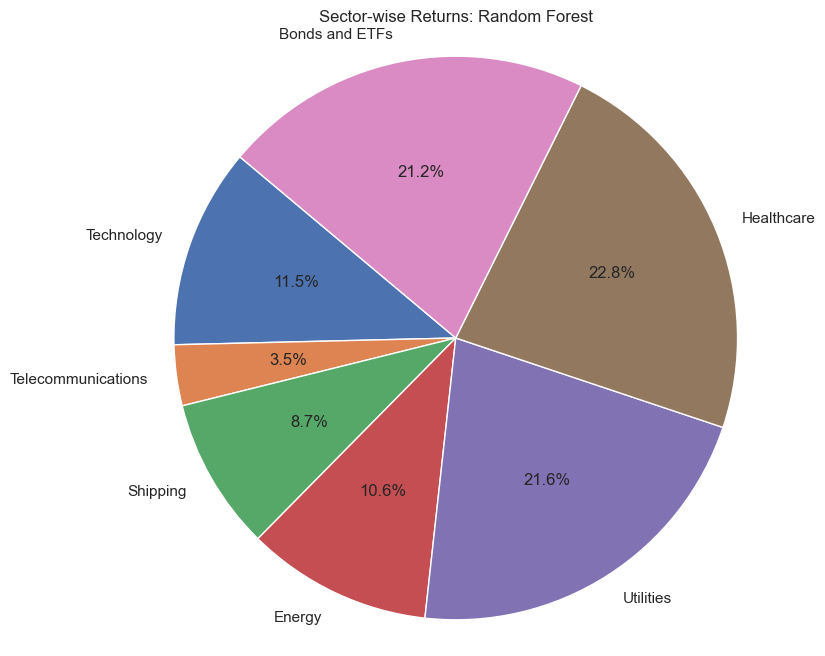


Sector-wise returns for SVM (Total Model Return: 61.80%):

            Sector  Return (%)
        Technology   11.061604
Telecommunications    8.651966
          Shipping    7.533077
            Energy    7.563603
         Utilities   23.397136
        Healthcare   19.538479
    Bonds and ETFs   22.254135
Saved sector-wise returns to SVM_sector_returns.csv


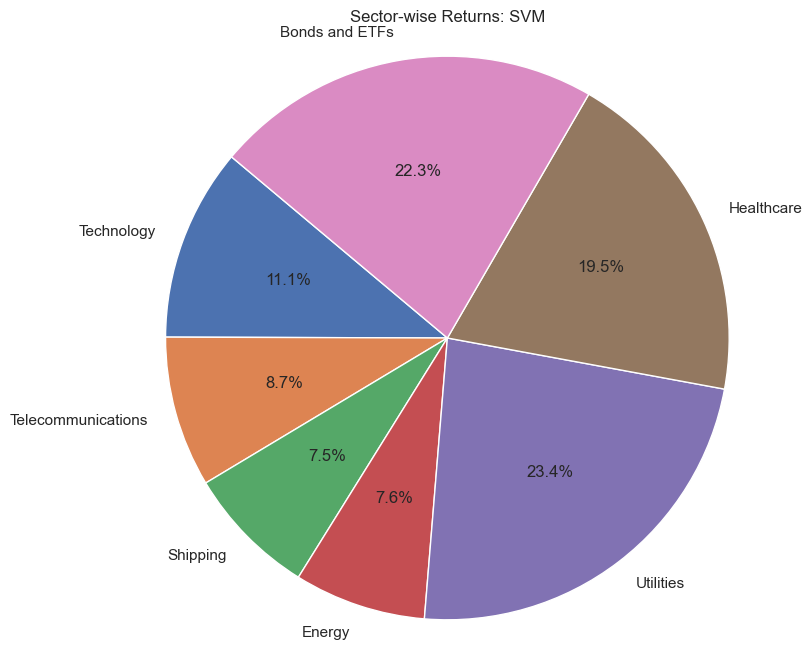


Sector-wise returns for DNN (Total Model Return: 50.00%):

            Sector  Return (%)
        Technology   13.228068
Telecommunications   10.925616
          Shipping    8.000149
            Energy    8.854937
         Utilities   11.385281
        Healthcare   23.451457
    Bonds and ETFs   24.154493
Saved sector-wise returns to DNN_sector_returns.csv


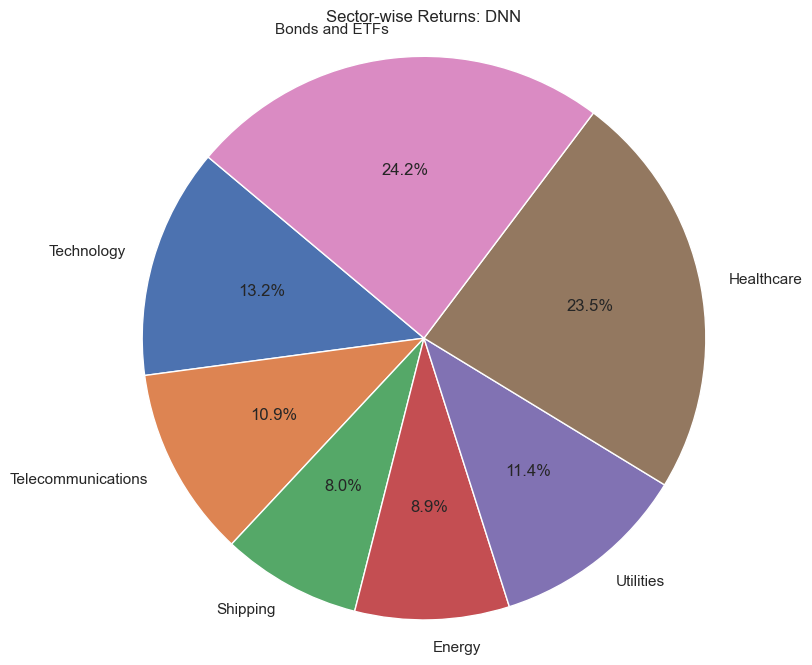

Saved cumulative returns to RF_cumulative_returns.csv
Saved cumulative returns to SVM_cumulative_returns.csv
Saved cumulative returns to DNN_cumulative_returns.csv


In [33]:
import os

# Function to calculate overall model returns
def calculate_model_returns(cumulative_returns):
    return sum(cumulative_returns)

def plot_pie_chart_and_table(returns, title, total_model_return, model_name):
    if returns:
        percentage_returns = {sector: (value / total_model_return) * 100 for sector, value in returns.items()}
        
        sector_returns_df = pd.DataFrame(list(percentage_returns.items()), columns=['Sector', 'Return (%)'])
        
        print(f"\nSector-wise returns for {title} (Total Model Return: {total_model_return:.2f}%):\n")
        print(sector_returns_df.to_string(index=False))
        
        sector_returns_csv = f"{model_name}_sector_returns.csv"
        sector_returns_df.to_csv(sector_returns_csv, index=False)
        print(f"Saved sector-wise returns to {sector_returns_csv}")
        
        plt.figure(figsize=(8, 8))
        plt.pie(percentage_returns.values(), labels=percentage_returns.keys(), autopct='%1.1f%%', startangle=140)
        plt.title(f'Sector-wise Returns: {title}')
        plt.axis('equal')
        plt.show()

def save_cumulative_returns(cumulative_returns, model_name):
    securities = [ticker for tickers in sectors.values() for ticker in tickers]
    cumulative_returns_df = pd.DataFrame(list(zip(securities, cumulative_returns)), columns=['Security', 'Cumulative Return (%)'])
    
    cumulative_returns_csv = f"{model_name}_cumulative_returns.csv"
    cumulative_returns_df.to_csv(cumulative_returns_csv, index=False)
    print(f"Saved cumulative returns to {cumulative_returns_csv}")

# Calculate and print overall model returns for each model
overall_rf_return = calculate_model_returns(overall_results['RF']['cumulative_returns'])
overall_svm_return = calculate_model_returns(overall_results['SVM']['cumulative_returns'])
overall_dnn_return = calculate_model_returns(overall_results['DNN']['cumulative_returns'])

# Plot sector-wise returns for each model, save results, and include total model returns
plot_pie_chart_and_table(overall_results['RF']['sector_returns'], "Random Forest", overall_rf_return, "RF")
plot_pie_chart_and_table(overall_results['SVM']['sector_returns'], "SVM", overall_svm_return, "SVM")
plot_pie_chart_and_table(overall_results['DNN']['sector_returns'], "DNN", overall_dnn_return, "DNN")

# Save cumulative returns for each security in each model to CSV
save_cumulative_returns(overall_results['RF']['cumulative_returns'], "RF")
save_cumulative_returns(overall_results['SVM']['cumulative_returns'], "SVM")
save_cumulative_returns(overall_results['DNN']['cumulative_returns'], "DNN")


# Key Formulas

## 1. Average Risk-Free Return
The formula for calculating the average risk-free return is given by:

$$
\text{Average Risk-Free Return} = \frac{1}{n} \sum_{i=1}^{n} r_i
$$


where \( r_i \) are the risk-free rates and \( n \) is the number of observations.

## 2. Dynamic Threshold
The dynamic threshold can be calculated using the following conditions:

$$
\text{Threshold} =
\begin{cases} 
\text{base threshold} - 2 & \text{if } \text{inflation rate} > 2.5 \\
\text{base threshold} - 3 & \text{if } \text{interest rate} > 3.0 \\
\text{base threshold} + 2 & \text{if } \text{GDP growth} > 3.0 \\
\text{base threshold} & \text{otherwise}
\end{cases}
$$


## 3. Percentage Returns for Each Sector
To calculate the percentage return for each sector, use:

$$
\text{Percentage Return}_{\text{sector}} = \left( \frac{\text{Sector Return}}{\text{Total Model Return}} \right) \times 100
$$


## 4. Total Return Calculation
The total return can be computed as follows:

$$
\text{Total Return} = \text{Initial Investment} + \sum \left( \text{Initial Investment} \times \left( \frac{\text{Sector Return}}{100} \right) \text{ if action is 'Long'} \right) - \prod \left( \left( 1 - \frac{\text{Sector Return}}{100} \right) \text{ if action is 'Short'} \right)
$$


## 5. Sharpe Ratio
The Sharpe ratio is defined as:

$$
\text{Sharpe Ratio} = \frac{\text{Mean of Cumulative Returns}}{\text{Standard Deviation of Cumulative Returns}}
$$


## 6. Volatility
Volatility can be calculated using:

$$
\text{Volatility} = \text{Standard Deviation of Cumulative Returns}
$$


## 7. Maximum Drawdown
To find the maximum drawdown, use:

$$
\text{Max Drawdown} = \max \left( \frac{\text{Peak} - \text{Value}}{\text{Peak}} \right)
$$


## 8. Alpha
Alpha is calculated as:

$$
\text{Alpha} = \text{Mean of Cumulative Returns} - \text{Benchmark Cumulative Return}
$$


## 9. Risk-Reward Ratio
The risk-reward ratio can be expressed as:

$$
\text{Risk-Reward Ratio} = 
\begin{cases}
\frac{\text{Average Return}}{\text{Max Drawdown}} & \text{if Max Drawdown } \neq 0\\
\end{cases}
$$


In [34]:

import requests
from datetime import datetime

# Function to calculate average risk-free return based on 10-Year Treasury yield
def calculate_average_risk_free_return(risk_free_rates):
    return np.mean(risk_free_rates)

# Function to fetch FRED data
def fetch_fred_data(api_key, series_id, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}"
    response = requests.get(url)
    data = response.json()
    if 'observations' in data:
        observations = data['observations']
        return [float(obs['value']) for obs in observations]  # Return all values
    else:
        raise Exception("Unable to fetch data from FRED")

def calculate_dynamic_threshold(inflation_rate, interest_rate, gdp_growth):
    base_threshold = 12.0  # Base threshold
    if inflation_rate > 2.5:  # High inflation, increase short positions
        threshold = base_threshold - 2
    elif interest_rate > 3.0:  # High interest rate, increase short positions
        threshold = base_threshold - 3
    elif gdp_growth > 3.0:  # High GDP growth, increase long positions
        threshold = base_threshold + 2
    else:
        threshold = base_threshold
    return threshold

# Function to decide long/short actions using the dynamic threshold
def decide_long_short_actions(sector_returns, total_model_return, threshold):
    actions = {}
    percentage_returns = {sector: (value / total_model_return) * 100 for sector, value in sector_returns.items()}
    for sector, return_percentage in percentage_returns.items():
        if return_percentage >= threshold:
            actions[sector] = 'Long'
        else:
            actions[sector] = 'Short'
    return actions

# Function to calculate total return based on actions
def calculate_total_return(initial_investment, sector_returns, actions):
    total_return = initial_investment  
    for sector, action in actions.items():
        return_percentage = sector_returns[sector]  
        if action == 'Long':
            total_return += initial_investment * (return_percentage / 100)
        else:  # Action is 'Short'
            total_return *= (1 - (return_percentage / 100))  
    return total_return

# Function to display sector-wise returns and decide long/short actions
def display_sector_returns_and_decide_actions(returns, title, total_model_return, model_name, threshold, initial_investment):
    if returns:
        long_short_actions = decide_long_short_actions(returns, total_model_return, threshold)
        percentage_returns = {sector: (value / total_model_return) * 100 for sector, value in returns.items()}
        
        sector_returns_df = pd.DataFrame(list(percentage_returns.items()), columns=['Sector', 'Return (%)'])
        sector_returns_df['Action'] = sector_returns_df['Return (%)'].apply(lambda x: 'Long' if x >= threshold else 'Short')
        
        # Calculate total return on initial investment
        total_return = calculate_total_return(initial_investment, returns, long_short_actions)
        total_return_percentage = (total_return / initial_investment - 1) * 100  # Calculate percentage gain
        
        # Calculate Sharpe Ratio and Volatility
        sharpe_ratio = calculate_sharpe_ratio(overall_results[model_name]['cumulative_returns'])
        volatility = calculate_volatility(overall_results[model_name]['cumulative_returns'])
        
        print(f"\nSector-wise returns and Long/Short actions for {title} (Total Model Return: {total_model_return:.2f}%):\n")
        print(sector_returns_df.to_string(index=False))
        print(f"\nTotal Return on Initial Investment of ${initial_investment:.2f}: ${total_return:.2f} ({total_return_percentage:.2f}%)")
        print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
        print(f"Volatility: {volatility:.4f}")
        
        sector_returns_csv = f"{model_name}_sector_returns_and_actions.csv"
        sector_returns_df.to_csv(sector_returns_csv, index=False)
        print(f"Saved sector-wise returns and Long/Short actions to {sector_returns_csv}")

# Function to calculate Sharpe Ratio
def calculate_sharpe_ratio(cumulative_returns):
    return np.mean(cumulative_returns) / np.std(cumulative_returns)

# Function to calculate Volatility
def calculate_volatility(cumulative_returns):
    return np.std(cumulative_returns)

# Function to calculate maximum drawdown
def calculate_max_drawdown(cumulative_returns):
    cumulative_returns = np.array(cumulative_returns)
    peak = cumulative_returns[0]
    max_drawdown = 0
    for x in cumulative_returns:
        if x > peak:
            peak = x
        drawdown = (peak - x) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    return max_drawdown

# Function to calculate alpha using S&P 500 benchmark
def calculate_alpha(cumulative_returns, benchmark_cumulative_return):
    excess_returns = np.mean(cumulative_returns) - benchmark_cumulative_return
    return excess_returns

# Function to calculate risk-reward ratio
def calculate_risk_reward_ratio(cumulative_returns):
    max_drawdown = calculate_max_drawdown(cumulative_returns)
    average_return = np.mean(cumulative_returns)
    return average_return / max_drawdown if max_drawdown != 0 else np.inf

# User-defined initial investment
initial_investment = float(input("Enter your initial investment amount: "))

# FRED API key and macroeconomic series IDs
FRED_API_KEY = 'ac193a95a7cf1fc14f2a13ff88dd9109'
INFLATION_SERIES_ID = 'CPIAUCSL'  # Consumer Price Index (inflation proxy)
INTEREST_RATE_SERIES_ID = 'FEDFUNDS'  # Federal Funds Rate (interest rate proxy)
GDP_SERIES_ID = 'GDP'  # GDP (for economic growth)
TEN_YEAR_TREASURY_SERIES_ID = 'GS10'  # 10-Year Treasury Constant Maturity Rate

# Set the start and end dates for fetching data
start_date = datetime.strptime("2020-01-01", "%Y-%m-%d").strftime("%Y-%m-%d")
end_date = datetime.strptime("2024-01-31", "%Y-%m-%d").strftime("%Y-%m-%d")

# Fetch latest macroeconomic data from FRED
inflation_rate = fetch_fred_data(FRED_API_KEY, INFLATION_SERIES_ID, start_date, end_date)[-1]
interest_rate = fetch_fred_data(FRED_API_KEY, INTEREST_RATE_SERIES_ID, start_date, end_date)[-1]
gdp_growth = fetch_fred_data(FRED_API_KEY, GDP_SERIES_ID, start_date, end_date)[-1]

# Fetch 10-Year Treasury yield data from FRED
risk_free_rates = fetch_fred_data(FRED_API_KEY, TEN_YEAR_TREASURY_SERIES_ID, start_date, end_date)

# Calculate average risk-free return
average_risk_free_return = calculate_average_risk_free_return(risk_free_rates)
print(f"Average Risk-Free Return (10-Year Treasury Yield) from {start_date} to {end_date}: {average_risk_free_return:.2f}%")

# Calculate dynamic threshold based on market conditions
dynamic_threshold = calculate_dynamic_threshold(inflation_rate, interest_rate, gdp_growth)
print(f"Dynamic Threshold based on market conditions: {dynamic_threshold:.2f}%")

# Benchmark values for S&P 500
benchmark_cumulative_return = 0.2763  # Cumulative Returns: 27.63%

# Fetch and calculate model returns and display sector-wise actions with dynamic threshold
overall_rf_return = calculate_model_returns(overall_results['RF']['cumulative_returns'])
overall_svm_return = calculate_model_returns(overall_results['SVM']['cumulative_returns'])
overall_dnn_return = calculate_model_returns(overall_results['DNN']['cumulative_returns'])

# Use the dynamic threshold in the display
display_sector_returns_and_decide_actions(overall_results['RF']['sector_returns'], "Random Forest", overall_rf_return, "RF", dynamic_threshold, initial_investment)
display_sector_returns_and_decide_actions(overall_results['SVM']['sector_returns'], "SVM", overall_svm_return, "SVM", dynamic_threshold, initial_investment)
display_sector_returns_and_decide_actions(overall_results['DNN']['sector_returns'], "DNN", overall_dnn_return, "DNN", dynamic_threshold, initial_investment)

# Calculate and display performance metrics including maximum drawdown and alpha
for model in ['RF', 'SVM', 'DNN']:
    cumulative_returns = overall_results[model]['cumulative_returns']
    max_drawdown = calculate_max_drawdown(cumulative_returns)
    alpha = calculate_alpha(cumulative_returns, benchmark_cumulative_return)
    risk_reward_ratio = calculate_risk_reward_ratio(cumulative_returns)
    print("           ")
    print(f"{model} Performance Metrics:")
    print(f"  Maximum Drawdown: {max_drawdown:.2f}")
    print(f"  Alpha: {alpha:.2f}")
    print(f"  Risk-Reward Ratio: {risk_reward_ratio:.2f}\n")


Enter your initial investment amount:  100000000


Average Risk-Free Return (10-Year Treasury Yield) from 2020-01-01 to 2024-01-31: 2.35%
Dynamic Threshold based on market conditions: 10.00%

Sector-wise returns and Long/Short actions for Random Forest (Total Model Return: 57.63%):

            Sector  Return (%) Action
        Technology   11.493954   Long
Telecommunications    3.486742  Short
          Shipping    8.743677  Short
            Energy   10.642017   Long
         Utilities   21.604674   Long
        Healthcare   22.802889   Long
    Bonds and ETFs   21.226047   Long

Total Return on Initial Investment of $100000000.00: $143177352.53 (43.18%)
Sharpe Ratio: 1.7372
Volatility: 0.8092
Saved sector-wise returns and Long/Short actions to RF_sector_returns_and_actions.csv

Sector-wise returns and Long/Short actions for SVM (Total Model Return: 61.80%):

            Sector  Return (%) Action
        Technology   11.061604   Long
Telecommunications    8.651966  Short
          Shipping    7.533077  Short
            Energy    7.5

# Explanation 
------
## 1. Total Return on Initial Investment
- This measures the actual dollar gain or loss based on your initial 100 million investment dollars. It represents the real-world profit or loss you would see if you had invested that amount at the start.
- For example, in the Random Forest model, the Total Return on Initial Investment is 43.18%, which means you earned an additional 41.9 million dollars on top of your initial 100 million dollars , bringing the total to approximately $143.18 million.

## 2. Total Model Return
- This is a theoretical percentage gain or loss based on the model's actions (e.g., going long or short on certain sectors), without being directly tied to the exact starting amount. It reflects how well the model itself performed based on its predictions and strategy.
- It does not take into account other factors such as cash balance or leverage.
- For instance, the Random Forest model had a Total Model Return of 57.63%, which is higher than the 43.18% on your $100 million because this return purely reflects the model’s predictive accuracy and strategic performance.

--------

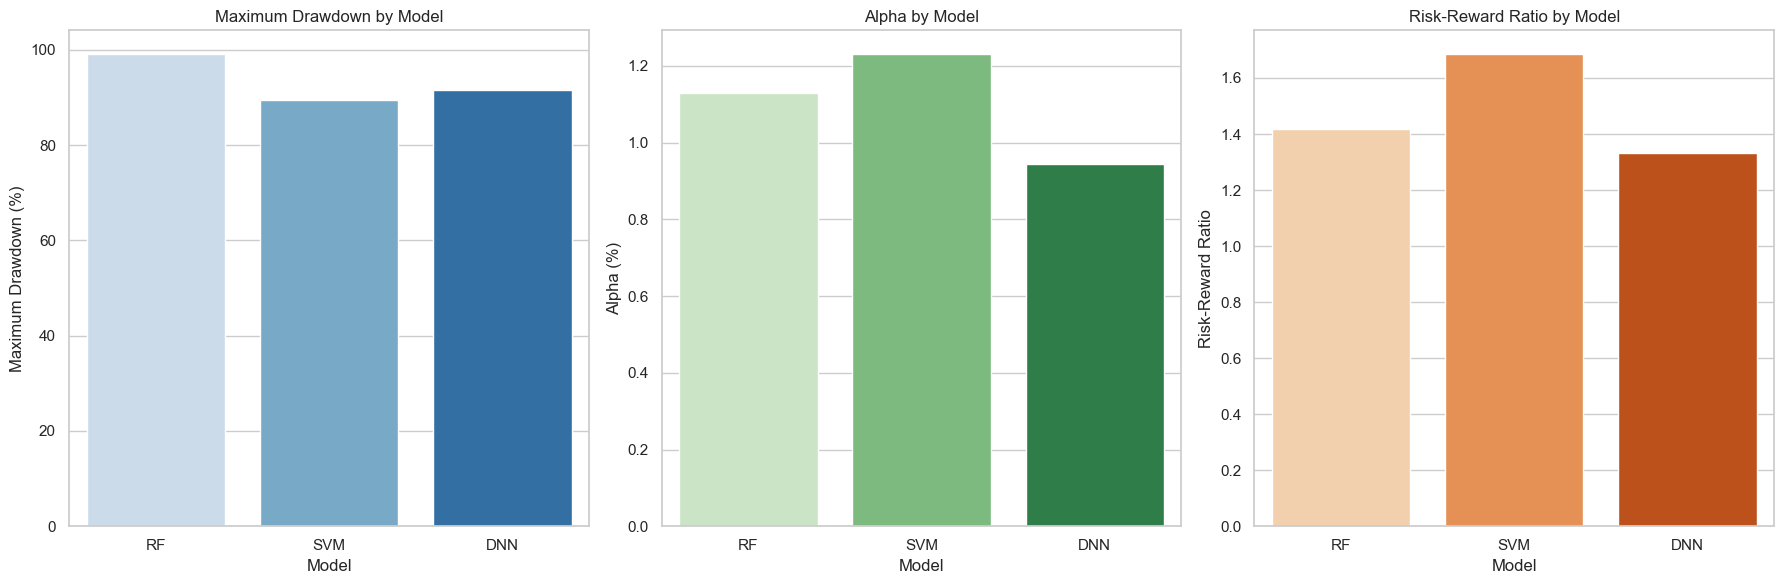

In [35]:

import seaborn as sns

sns.set(style="whitegrid")
def create_performance_metrics_df(overall_results, benchmark_cumulative_return):
    metrics_data = []
    for model in ['RF', 'SVM', 'DNN']:
        cumulative_returns = overall_results[model]['cumulative_returns']
        max_drawdown = calculate_max_drawdown(cumulative_returns)
        alpha = calculate_alpha(cumulative_returns, benchmark_cumulative_return)
        risk_reward_ratio = calculate_risk_reward_ratio(cumulative_returns)
        
        metrics_data.append({
            'Model': model,
            'Maximum Drawdown': max_drawdown * 100,  
            'Alpha': alpha,
            'Risk-Reward Ratio': risk_reward_ratio
        })
    
    performance_metrics_df = pd.DataFrame(metrics_data)
    return performance_metrics_df

performance_metrics_df = create_performance_metrics_df(overall_results, benchmark_cumulative_return)

def visualize_performance_metrics(performance_metrics_df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    sns.barplot(data=performance_metrics_df, x='Model', y='Maximum Drawdown', ax=axes[0], palette='Blues')
    axes[0].set_title('Maximum Drawdown by Model')
    axes[0].set_ylabel('Maximum Drawdown (%)')
    
    sns.barplot(data=performance_metrics_df, x='Model', y='Alpha', ax=axes[1], palette='Greens')
    axes[1].set_title('Alpha by Model')
    axes[1].set_ylabel('Alpha (%)')
    
    sns.barplot(data=performance_metrics_df, x='Model', y='Risk-Reward Ratio', ax=axes[2], palette='Oranges')
    axes[2].set_title('Risk-Reward Ratio by Model')
    axes[2].set_ylabel('Risk-Reward Ratio')
    
    plt.tight_layout()
    plt.show()

visualize_performance_metrics(performance_metrics_df)



Stress Test Results for RF:
Adjusted Sector Returns:
  Technology: -3.38%
  Telecommunications: -2.99%
  Shipping: -9.96%
  Energy: -13.87%
  Utilities: 17.45%
  Healthcare: 23.14%
  Bonds and ETFs: 14.23%
Total Return under Recession Scenario: 24.63%

Stress Test Results for SVM:
Adjusted Sector Returns:
  Technology: -3.16%
  Telecommunications: 0.35%
  Shipping: -10.34%
  Energy: -15.33%
  Utilities: 19.46%
  Healthcare: 22.08%
  Bonds and ETFs: 15.75%
Total Return under Recession Scenario: 28.80%

Stress Test Results for DNN:
Adjusted Sector Returns:
  Technology: -3.39%
  Telecommunications: 0.46%
  Shipping: -11.00%
  Energy: -15.57%
  Utilities: 10.69%
  Healthcare: 21.73%
  Bonds and ETFs: 14.08%
Total Return under Recession Scenario: 17.00%


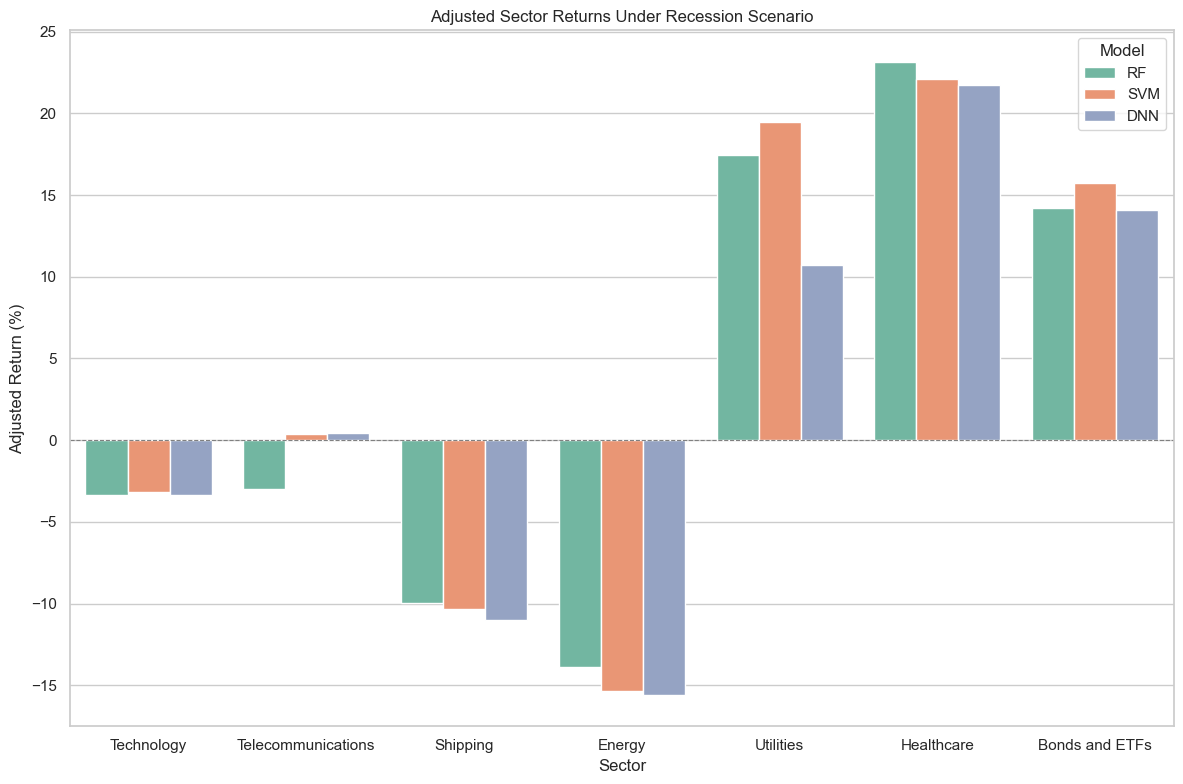

In [36]:
# Define expected sector returns during a recession
recession_sector_returns = {
    'Technology': -10,  # Expecting a decline
    'Telecommunications': -5,  # Slight decline
    'Shipping': -15,  # Expecting a significant decline
    'Energy': -20,  # Significant decline
    'Utilities': 5,  # Expected to hold steady or slightly grow
    'Healthcare': 10,  # Expected to grow or hold steady
    'Bonds and ETFs': 2  # Slight growth due to safe haven demand
}
# Function to perform stress test under recession scenario
def perform_stress_test(overall_results, recession_sector_returns):
    stress_test_results = {}
    
    for model in overall_results.keys():
        sector_returns = overall_results[model]['sector_returns']
        new_returns = {}
        
        for sector, original_return in sector_returns.items():
            # Adjust the original return based on recession assumptions
            adjusted_return = original_return + recession_sector_returns.get(sector, 0)
            new_returns[sector] = adjusted_return
        
        # Calculate total return for the model under recession scenario
        total_model_return = sum(new_returns.values()) 
        stress_test_results[model] = {
            'adjusted_sector_returns': new_returns,
            'total_return': total_model_return
        }
    
    return stress_test_results

# Execute the stress test
stress_test_results = perform_stress_test(overall_results, recession_sector_returns)

# Display results of the stress test
for model, results in stress_test_results.items():
    print(f"\nStress Test Results for {model}:")
    print("Adjusted Sector Returns:")
    for sector, return_value in results['adjusted_sector_returns'].items():
        print(f"  {sector}: {return_value:.2f}%")
    print(f"Total Return under Recession Scenario: {results['total_return']:.2f}%")


# Execute the stress test using your function
stress_test_results = perform_stress_test(overall_results, recession_sector_returns)

# Prepare data for visualization
data_for_viz = []

for model, results in stress_test_results.items():
    for sector, return_value in results['adjusted_sector_returns'].items():
        data_for_viz.append({'Model': model, 'Sector': sector, 'Adjusted Return': return_value})


viz_df = pd.DataFrame(data_for_viz)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(data=viz_df, x='Sector', y='Adjusted Return', hue='Model', palette='Set2')
plt.title('Adjusted Sector Returns Under Recession Scenario')
plt.ylabel('Adjusted Return (%)')
plt.xlabel('Sector')
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')
plt.legend(title='Model')
plt.tight_layout()
plt.show()
